In [1]:
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from nn import FunctionModel, save_model, load_model
import copy
import matplotlib.pyplot as plt
from muller_potential import MullerPotential
from model_training import train,pinn_loss,build_rightside

In [2]:
ndim = 2
gamma = 5
kbt = 10
lam = 10
eta = 10
omega = gamma

args = {
        "ndim": ndim,
        "gamma": gamma,
        "kbt": kbt,
        "lam": lam,
        "eta": eta,
        "omega": omega
    }



# sample 
'''
Nx_sample = 1000
Nv_sample = 1000
'''
N_sample = 10**6
NA = 5000
NB = 5000

batch_size = 2048 #not implement

layers = [2*ndim,8,64,64,8,1]
activ  = 'sigmoid'

alpha_t = 1
T = 200
Nt = int(T/alpha_t)
Nsteps = 20
lr = 1e-3

device = torch.device(
                "cuda" if torch.cuda.is_available() else "cpu")


xmin,xmax = -1.5,1.2
ymin,ymax = -.2,2
x1 = (torch.rand(size=(N_sample,1),dtype=torch.float32))*(xmax-xmin)+xmin
x2 = (torch.rand(size=(N_sample,1),dtype=torch.float32))*(ymax-ymin)+ymin
x = torch.cat((x1,x2),dim=1)
potential = MullerPotential()

UU = potential.potential(x).numpy()
x = x[UU<100,:]
N_sample = x.shape[0]
print(f"N_Sample: {N_sample}")


v = torch.randn(size=(N_sample,ndim),dtype = torch.float32)*np.sqrt(kbt)
data = torch.cat((x,v),dim=1)
w = torch.ones(size=(data.shape[0],1),dtype=torch.float32)
w = w/torch.sum(w)
dU = potential.gradient(data[:,:ndim])


r=0.2
vA = torch.randn(size=(NA,ndim),dtype = torch.float32)*np.sqrt(kbt)
xA = torch.from_numpy(potential.points_in_a(NA,r).astype(np.float32))
xA = torch.cat((xA,vA),dim=1)
vB = torch.randn(size=(NB,ndim),dtype = torch.float32)*np.sqrt(kbt)
xB = torch.from_numpy(potential.points_in_b(NB,r).astype(np.float32))
xB = torch.cat((xB,vB),dim=1)
labelA = 0*torch.ones_like(xA[:,0])
labelB = 1*torch.ones_like(xB[:,0])

data_b = torch.cat((xA,xB),dim=0)
label_b = torch.cat((labelA,labelB),dim=0).unsqueeze(dim=1)
print(label_b.shape)
del xA,xB,labelA,labelB



q = FunctionModel(layer_sizes=layers,activation=activ)
#model_file = f'./model/gamma10_kbt0.5_1I.pth'
#config_file = f'./config/gamma10_kbt0.5_1I.txt'
#q = load_model(model_file,config_file)


    

N_Sample: 827519
torch.Size([10000, 1])


In [3]:
args['lam'] = .10
args['eta'] = .10

In [5]:
## initialize
data.requires_grad_(True)
q.to(device)
data = data.to(device)
batch_size = 2**22
#eta = 10
#lr = 1e-3
# kbt = 1
loss_list,b_loss_list,tot_loss_list,pinn_loss_list=train(model=q,
                                          data=data,
                                          w=w,
                                          batchsize=batch_size,
                                          data_b=data_b,
                                          label_b=label_b,
                                          alpha_b=100,
                                          lr = 1e-3,
                                          num_tsteps=Nt*2,
                                          num_epoches=Nsteps,
                                          device=device,
                                          args=args,
                                          dU=dU,
                                          checkpoint=10,
                                          adaptive=False)

itr0: Building dataset!
itr0: Training!
itr0: Training completed!
itr1: Building dataset!
itr1: Training!
itr1: Training completed!
itr2: Building dataset!
itr2: Training!
itr2: Training completed!
itr3: Building dataset!
itr3: Training!


KeyboardInterrupt: 

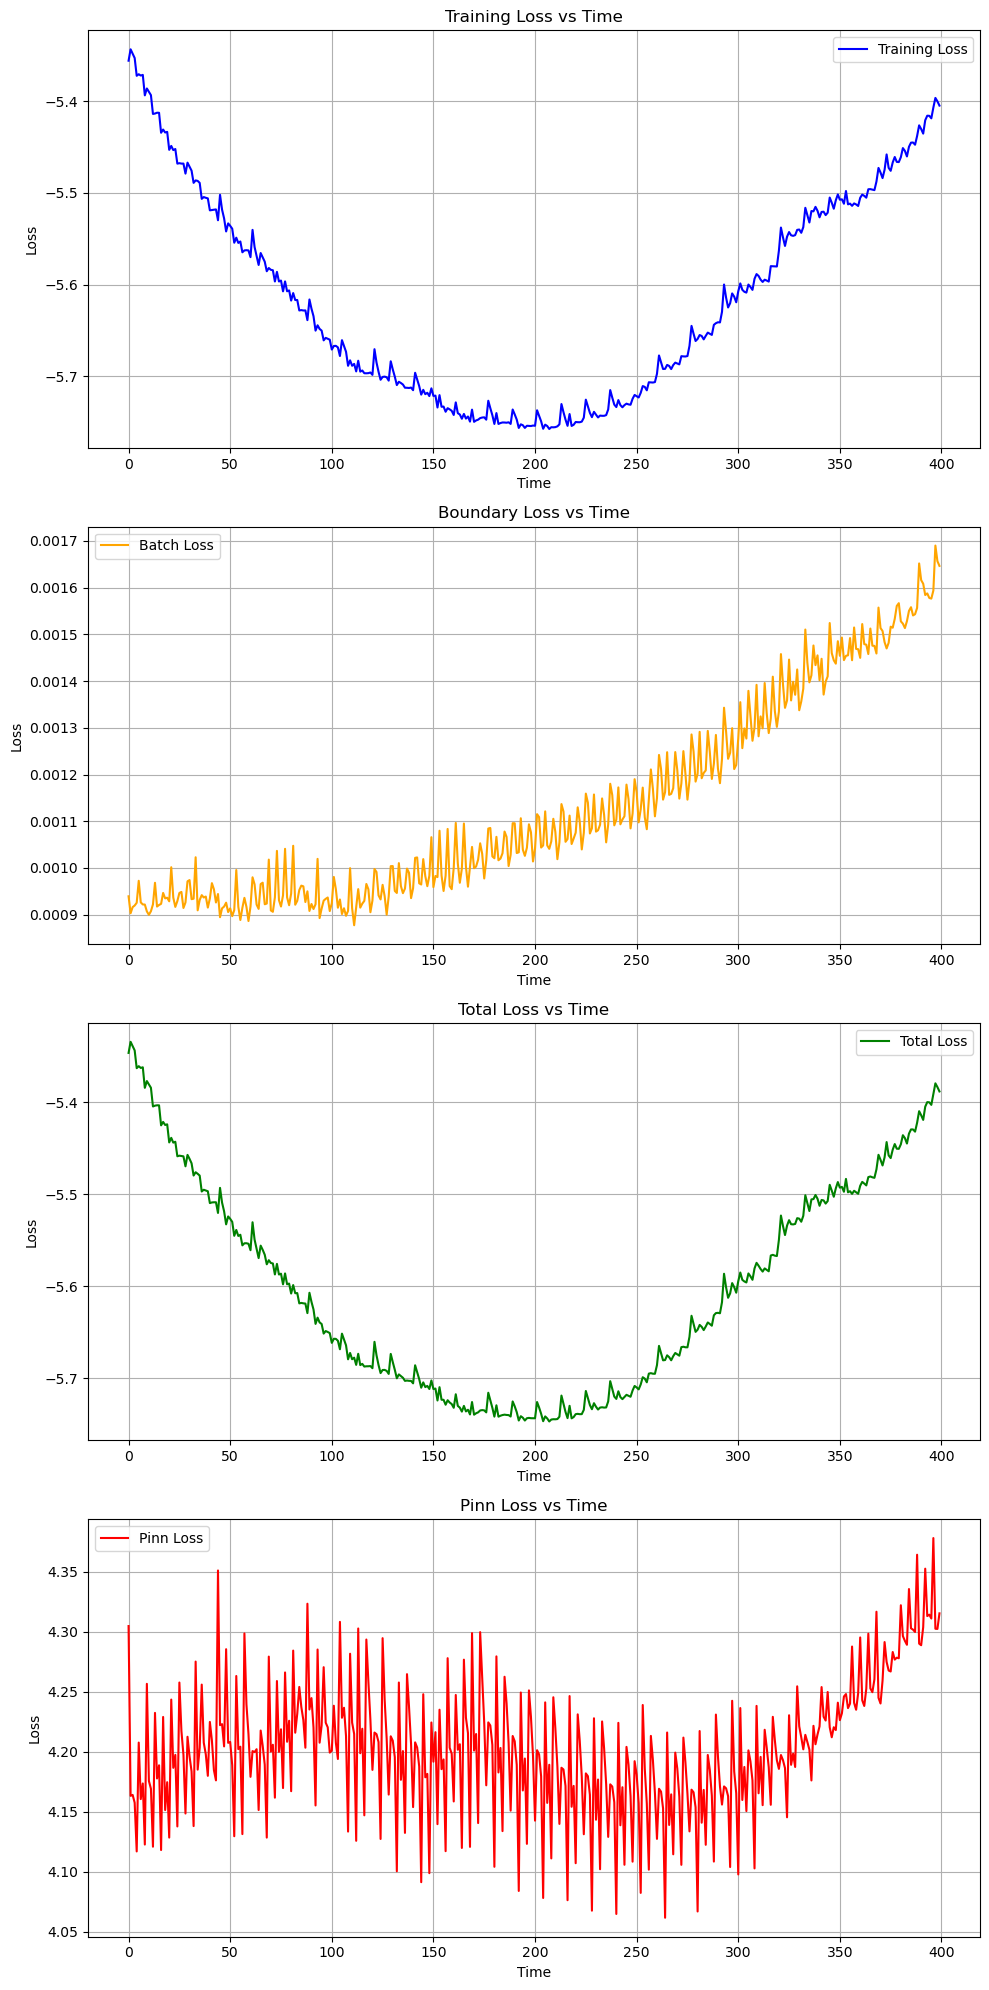

In [ ]:
t = np.arange(len(loss_list))  # Time values  


# Create a figure with 3 subplots  
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  

# Plot training loss  
axs[0].plot(t, loss_list, label='Training Loss', color='blue')  
axs[0].set_title('Training Loss vs Time')  
axs[0].set_xlabel('Time')  
axs[0].set_ylabel('Loss')  
axs[0].legend()  
axs[0].grid()  

# Plot batch loss  
axs[1].plot(t, b_loss_list, label='Batch Loss', color='orange')  
axs[1].set_title('Boundary Loss vs Time')  
axs[1].set_xlabel('Time')  
axs[1].set_ylabel('Loss')  
axs[1].legend()  
axs[1].grid()  

# Plot total loss  
axs[2].plot(t, tot_loss_list, label='Total Loss', color='green')  
axs[2].set_title('Total Loss vs Time')  
axs[2].set_xlabel('Time')  
axs[2].set_ylabel('Loss')  
axs[2].legend()  
axs[2].grid()  

axs[3].plot(t, pinn_loss_list, label='Pinn Loss', color='red')  
axs[3].set_title('Pinn Loss vs Time')  
axs[3].set_xlabel('Time')  
axs[3].set_ylabel('Loss')  
axs[3].legend()  
axs[3].grid() 

# Adjust layout  
plt.tight_layout()  
plt.show()  

In [ ]:
args['lam'] = 1
args['eta'] = 1


In [ ]:

data.requires_grad_(True)
q.to(device)
data = data.to(device)
batch_size = 2**22
#eta = 10
lr = 1e-4
#eta = 1
#lam = 1
#kbt = .5
loss_list,b_loss_list,tot_loss_list,pinn_loss_list=train(model=q,
                                          data=data,
                                          w=w,
                                          batchsize=batch_size,
                                          data_b=data_b,
                                          label_b=label_b,
                                          alpha_b=100,
                                          lr = lr,
                                          num_tsteps=Nt*10,
                                          num_epoches=20,
                                          device=device,
                                          args=args,
                                          dU=dU,
                                          checkpoint=10,
                                          adaptive=False)

itr0: Building dataset!
itr0: Training!
itr0: Training completed!
itr1: Building dataset!
itr1: Training!
itr1: Training completed!
itr2: Building dataset!
itr2: Training!
itr2: Training completed!
itr3: Building dataset!
itr3: Training!
itr3: Training completed!
itr4: Building dataset!
itr4: Training!
itr4: Training completed!
itr5: Building dataset!
itr5: Training!
itr5: Training completed!
itr6: Building dataset!
itr6: Training!
itr6: Training completed!
itr7: Building dataset!
itr7: Training!
itr7: Training completed!
itr8: Building dataset!
itr8: Training!
itr8: Training completed!
itr9: Building dataset!
itr9: Training!
itr9: Training completed!
itr10: Building dataset!
itr10: Training!
itr10: Training completed!
itr11: Building dataset!
itr11: Training!
itr11: Training completed!
itr12: Building dataset!
itr12: Training!
itr12: Training completed!
itr13: Building dataset!
itr13: Training!
itr13: Training completed!
itr14: Building dataset!
itr14: Training!
itr14: Training comple

KeyboardInterrupt: 

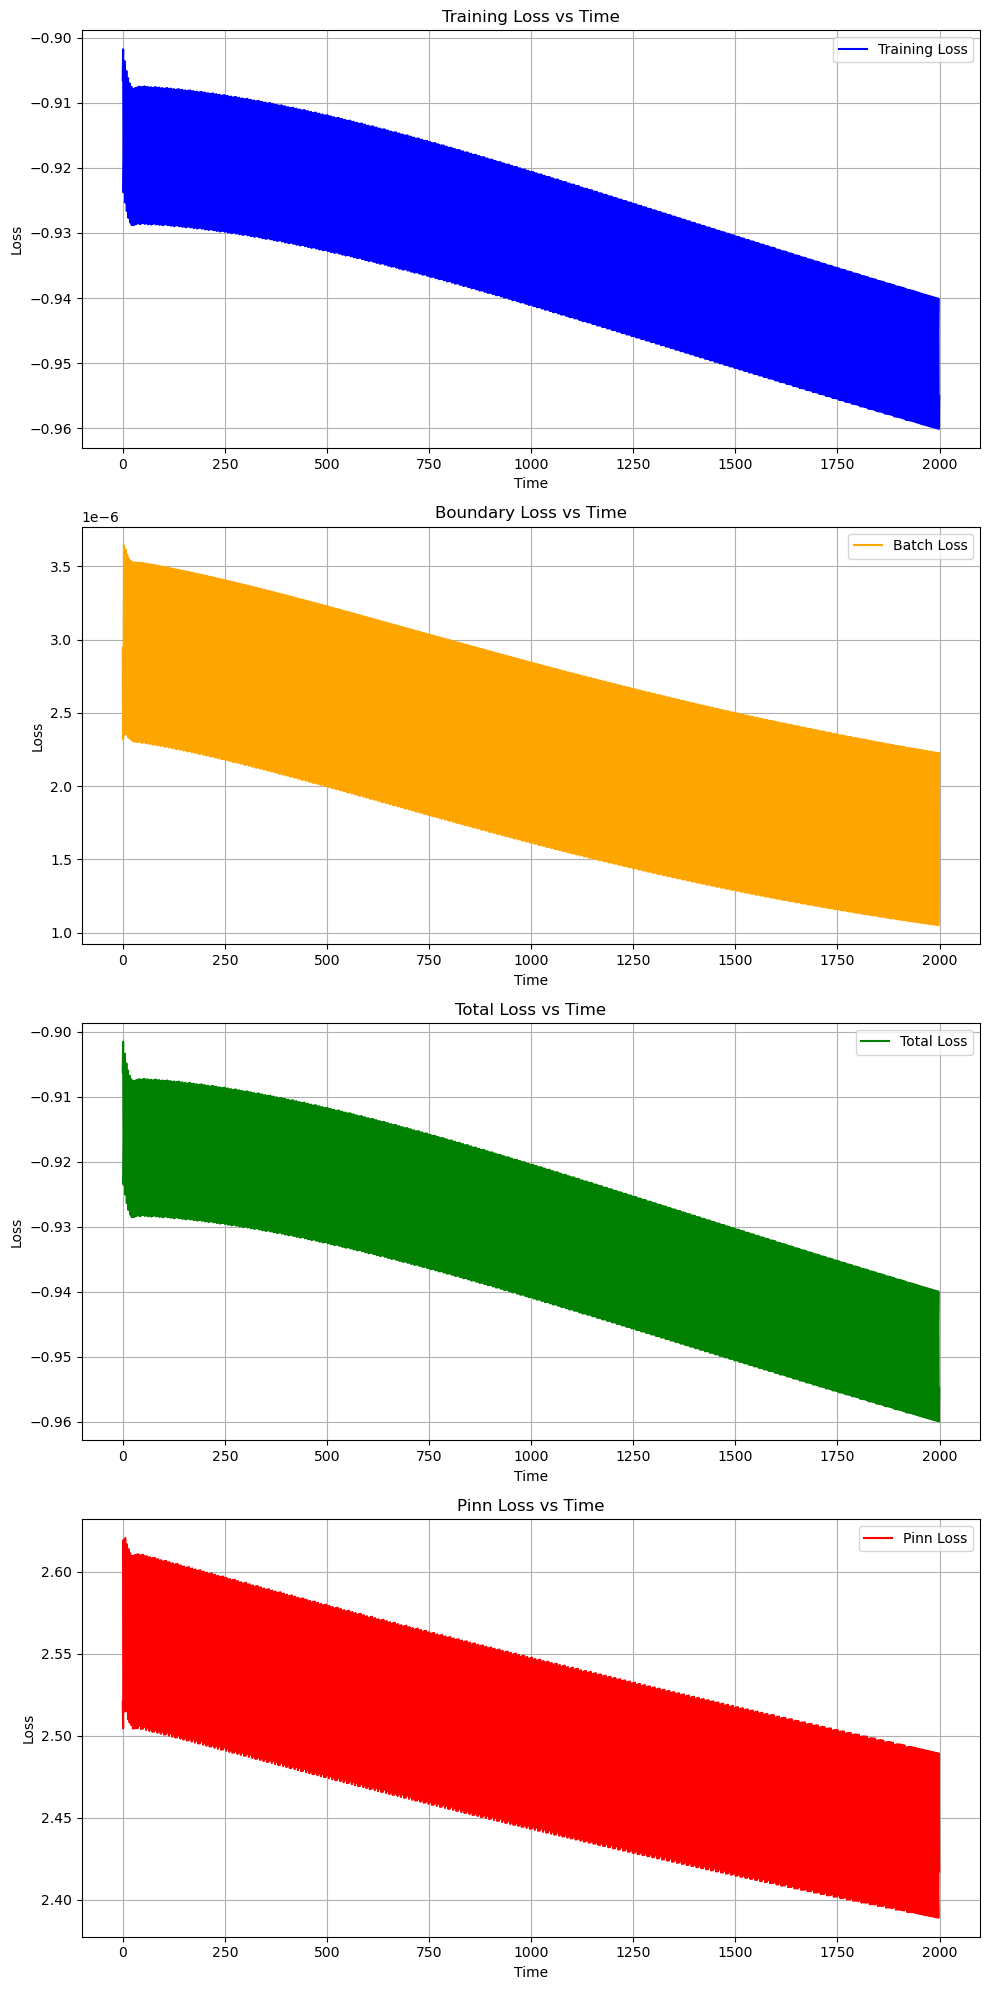

In [ ]:
t = np.arange(len(loss_list))  # Time values  


# Create a figure with 3 subplots  
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  

# Plot training loss  
axs[0].plot(t, loss_list, label='Training Loss', color='blue')  
axs[0].set_title('Training Loss vs Time')  
axs[0].set_xlabel('Time')  
axs[0].set_ylabel('Loss')  
axs[0].legend()  
axs[0].grid()  

# Plot batch loss  
axs[1].plot(t, b_loss_list, label='Batch Loss', color='orange')  
axs[1].set_title('Boundary Loss vs Time')  
axs[1].set_xlabel('Time')  
axs[1].set_ylabel('Loss')  
axs[1].legend()  
axs[1].grid()  

# Plot total loss  
axs[2].plot(t, tot_loss_list, label='Total Loss', color='green')  
axs[2].set_title('Total Loss vs Time')  
axs[2].set_xlabel('Time')  
axs[2].set_ylabel('Loss')  
axs[2].legend()  
axs[2].grid()  

axs[3].plot(t, pinn_loss_list, label='Pinn Loss', color='red')  
axs[3].set_title('Pinn Loss vs Time')  
axs[3].set_xlabel('Time')  
axs[3].set_ylabel('Loss')  
axs[3].legend()  
axs[3].grid() 

# Adjust layout  
plt.tight_layout()  
plt.show()  

In [ ]:
args['eta'] = 10
args['lam'] = 10

In [ ]:
data.requires_grad_(True)
q.to(device)
data = data.to(device)
batch_size = 2**22
#eta = 10
lr = 1e-4
#eta = 1
#lam = 1
#kbt = .5
loss_list,b_loss_list,tot_loss_list,pinn_loss_list=train(model=q,
                                          data=data,
                                          w=w,
                                          batchsize=batch_size,
                                          data_b=data_b,
                                          label_b=label_b,
                                          alpha_b=100,
                                          lr = lr,
                                          num_tsteps=Nt*10,
                                          num_epoches=20,
                                          device=device,
                                          args=args,
                                          dU=dU,
                                          checkpoint=10,
                                          adaptive=False,
                                          threshold=1)

itr0: Building dataset!
itr0: Training!
itr0: Training completed!
itr1: Building dataset!
itr1: Training!
itr1: Training completed!
itr2: Building dataset!
itr2: Training!
itr2: Training completed!
itr3: Building dataset!
itr3: Training!
itr3: Training completed!
itr4: Building dataset!
itr4: Training!
itr4: Training completed!
itr5: Building dataset!
itr5: Training!
itr5: Training completed!
itr6: Building dataset!
itr6: Training!
itr6: Training completed!
itr7: Building dataset!
itr7: Training!
itr7: Training completed!
itr8: Building dataset!
itr8: Training!
itr8: Training completed!
itr9: Building dataset!
itr9: Training!
itr9: Training completed!
itr10: Building dataset!
itr10: Training!
itr10: Training completed!
itr11: Building dataset!
itr11: Training!
itr11: Training completed!
itr12: Building dataset!
itr12: Training!
itr12: Training completed!
itr13: Building dataset!
itr13: Training!
itr13: Training completed!
itr14: Building dataset!
itr14: Training!
itr14: Training comple

In [ ]:
print(args['lam'],args['eta'],args['omega'])

10 10 5


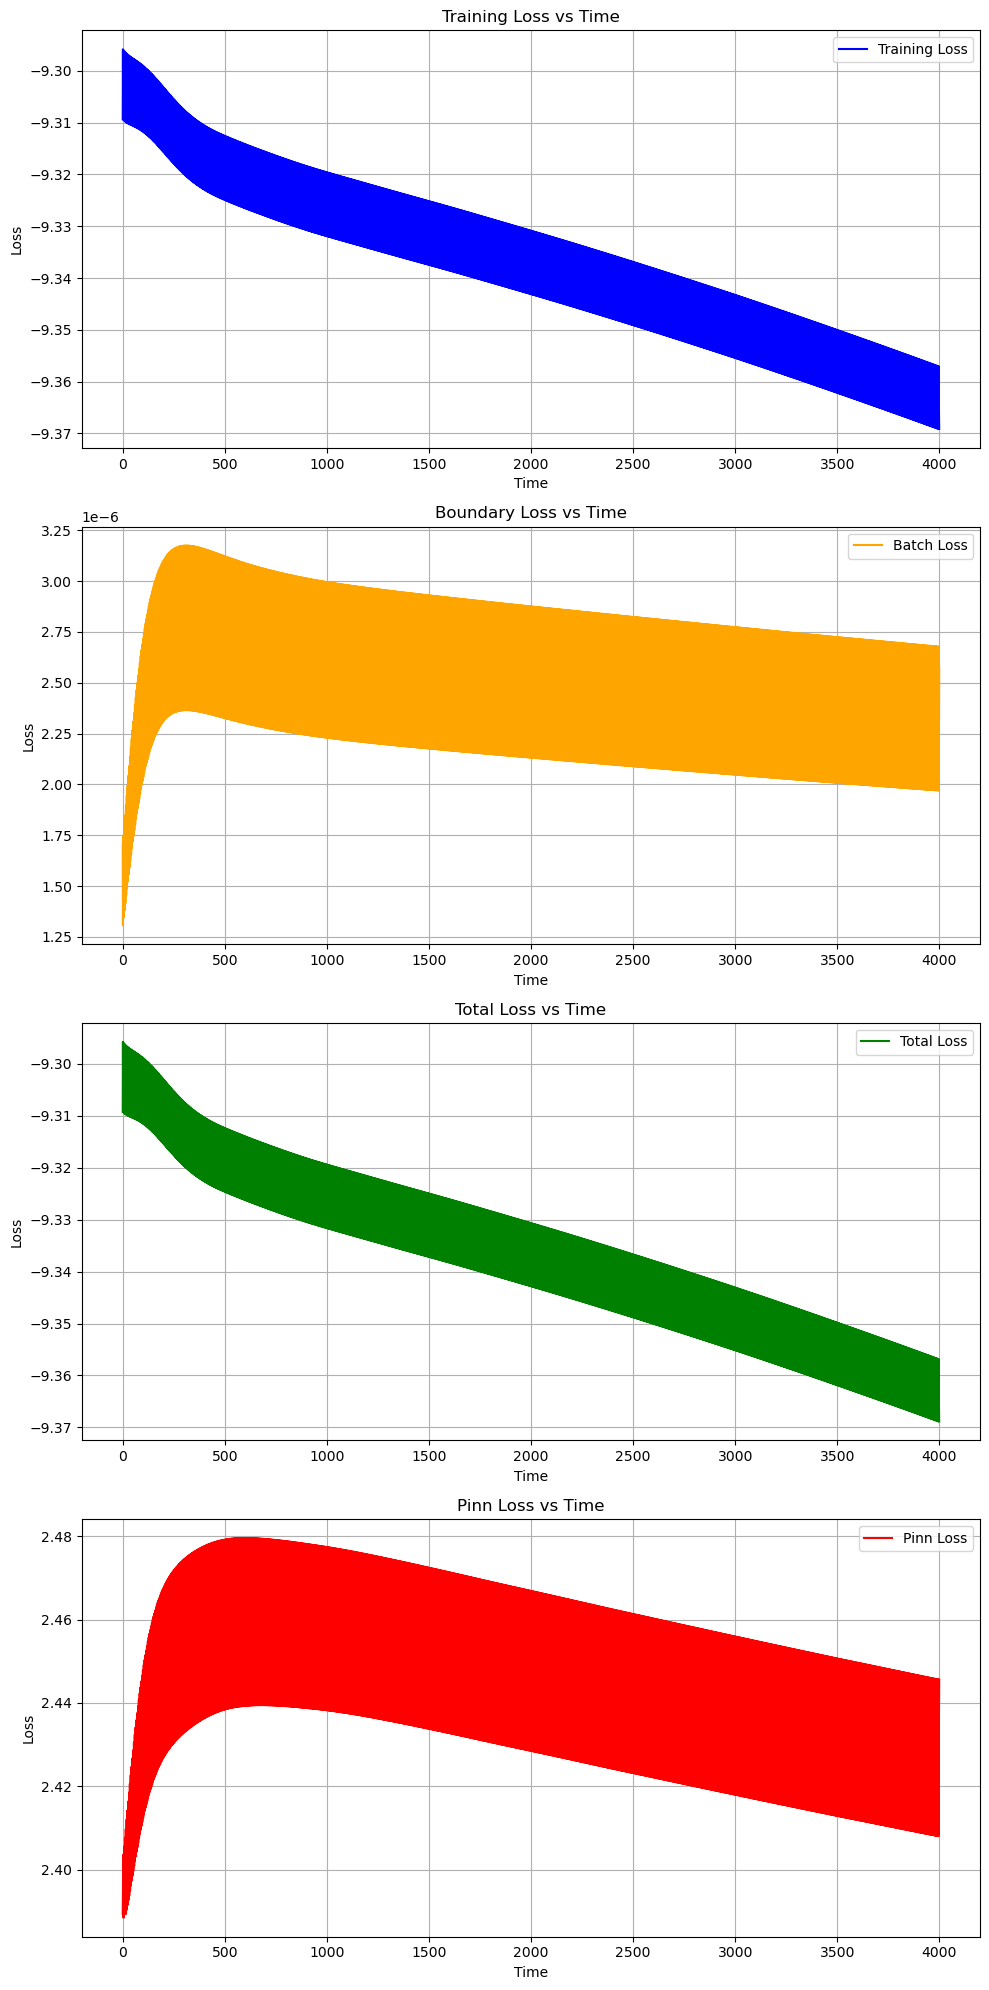

In [ ]:
 # Length of the data  
t = np.arange(len(loss_list))  # Time values  


# Create a figure with 3 subplots  
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  

# Plot training loss  
axs[0].plot(t, loss_list, label='Training Loss', color='blue')  
axs[0].set_title('Training Loss vs Time')  
axs[0].set_xlabel('Time')  
axs[0].set_ylabel('Loss')  
axs[0].legend()  
axs[0].grid()  

# Plot batch loss  
axs[1].plot(t, b_loss_list, label='Batch Loss', color='orange')  
axs[1].set_title('Boundary Loss vs Time')  
axs[1].set_xlabel('Time')  
axs[1].set_ylabel('Loss')  
axs[1].legend()  
axs[1].grid()  

# Plot total loss  
axs[2].plot(t, tot_loss_list, label='Total Loss', color='green')  
axs[2].set_title('Total Loss vs Time')  
axs[2].set_xlabel('Time')  
axs[2].set_ylabel('Loss')  
axs[2].legend()  
axs[2].grid()  

axs[3].plot(t, pinn_loss_list, label='Pinn Loss', color='red')  
axs[3].set_title('Pinn Loss vs Time')  
axs[3].set_xlabel('Time')  
axs[3].set_ylabel('Loss')  
axs[3].legend()  
axs[3].grid() 

# Adjust layout  
plt.tight_layout()  
plt.show()  

In [4]:
xmin, xmax = -1.5, 1.2
ymin, ymax = -0.2, 2
dx = 0.01
dy = 0.01
Nx = int((xmax - xmin) / dx)
Ny = int((ymax - ymin) / dy)


Ncol = Nx + 1
Nrow = Ny + 1
x = np.linspace(xmin, xmax, Nx + 1)
y = np.linspace(ymin, ymax, Ny + 1)

if Ncol == Nx - 1:
    xcal = x[1:-1]
else:
    xcal = x

if Nrow == Ny - 1:
    ycal = y[1:-1]
else:
    ycal = y


X, Y = np.meshgrid(xcal, ycal)
# print(X.shape, V)

points = np.array([X.reshape(-1), Y.reshape(-1)]).T.astype(np.float32)
UU = potential.potential(points).reshape(X.shape)
UU[UU>0] = 0
'''
c = np.arange(len(points))
plt.scatter(points[:, 0], points[:, 1], c=c)
plt.colorbar()
plt.show()
'''
N_matrix = Nrow * Ncol

ddd = torch.zeros(size=(points.shape[0],2*ndim)).to(device)

ddd[:,:ndim] = torch.from_numpy(points).to(device)
ddd[:,ndim:] = 0
qqq = torch.zeros(size=(ddd.shape[0],1),dtype=torch.float32,device=device)
NNN = 1000
with torch.no_grad():
    for ttt in range(NNN):
        
        ddd[:,ndim:] = torch.randn(size=(1,ndim),device=device)*torch.ones(size=(ddd.shape[0],ndim),device=device)*np.sqrt(kbt)
        #print(ddd.shape)
        temp = q(ddd)
        
        #print(ddd.shape,temp.shape)
        qqq += temp

qqq = qqq/NNN
qqq = qqq.squeeze().to('cpu').detach()
ddd.requires_grad_(True)
y = q(ddd)
dU1 = potential.gradient(ddd[:,:ndim])
print(y.shape,ddd.shape,dU1.shape)
pinn_l = pinn_loss(y,ddd,dU1,args)
pinn_l = pinn_l.detach().cpu().numpy()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

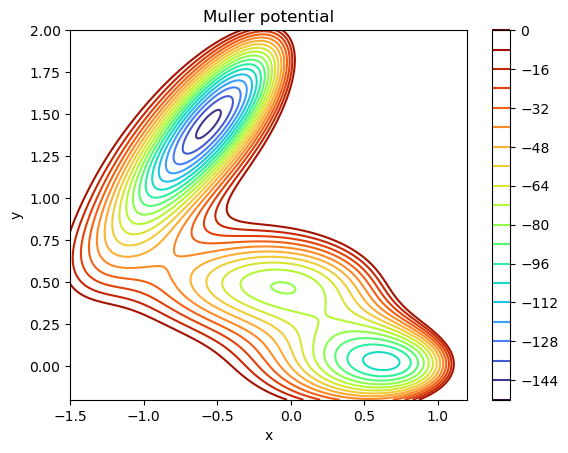

In [8]:
contour = plt.contour(
        X,
        Y,
        UU, levels=20,
        cmap='turbo')  # 20 contour levels
#plt.scatter(points[:, 0], points[:, 1], c=qqq)
plt.title('Muller potential')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

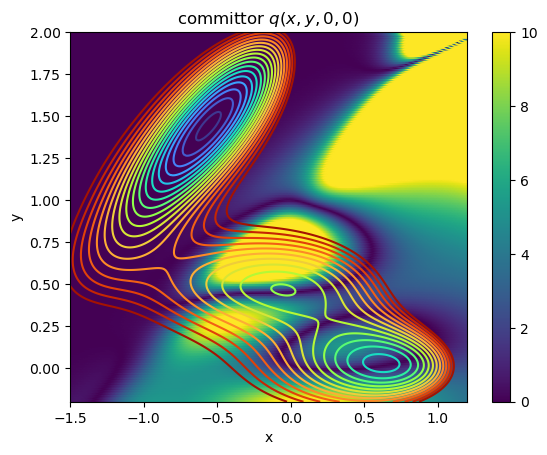

In [ ]:
mmm = np.abs(pinn_l)
mmm[mmm>10] = 10
contour = plt.contour(
        X,
        Y,
        UU, levels=20,
        cmap='turbo')  # 20 contour levels
plt.scatter(points[:, 0], points[:, 1], c=mmm)
plt.title('committor $q(x,y,0,0)$')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [ ]:
vs = np.loadtxt(f'model/simulation_{kbt}/simulation_vconfig_kbt{kbt}.txt')
v_sample = vs.shape[0]

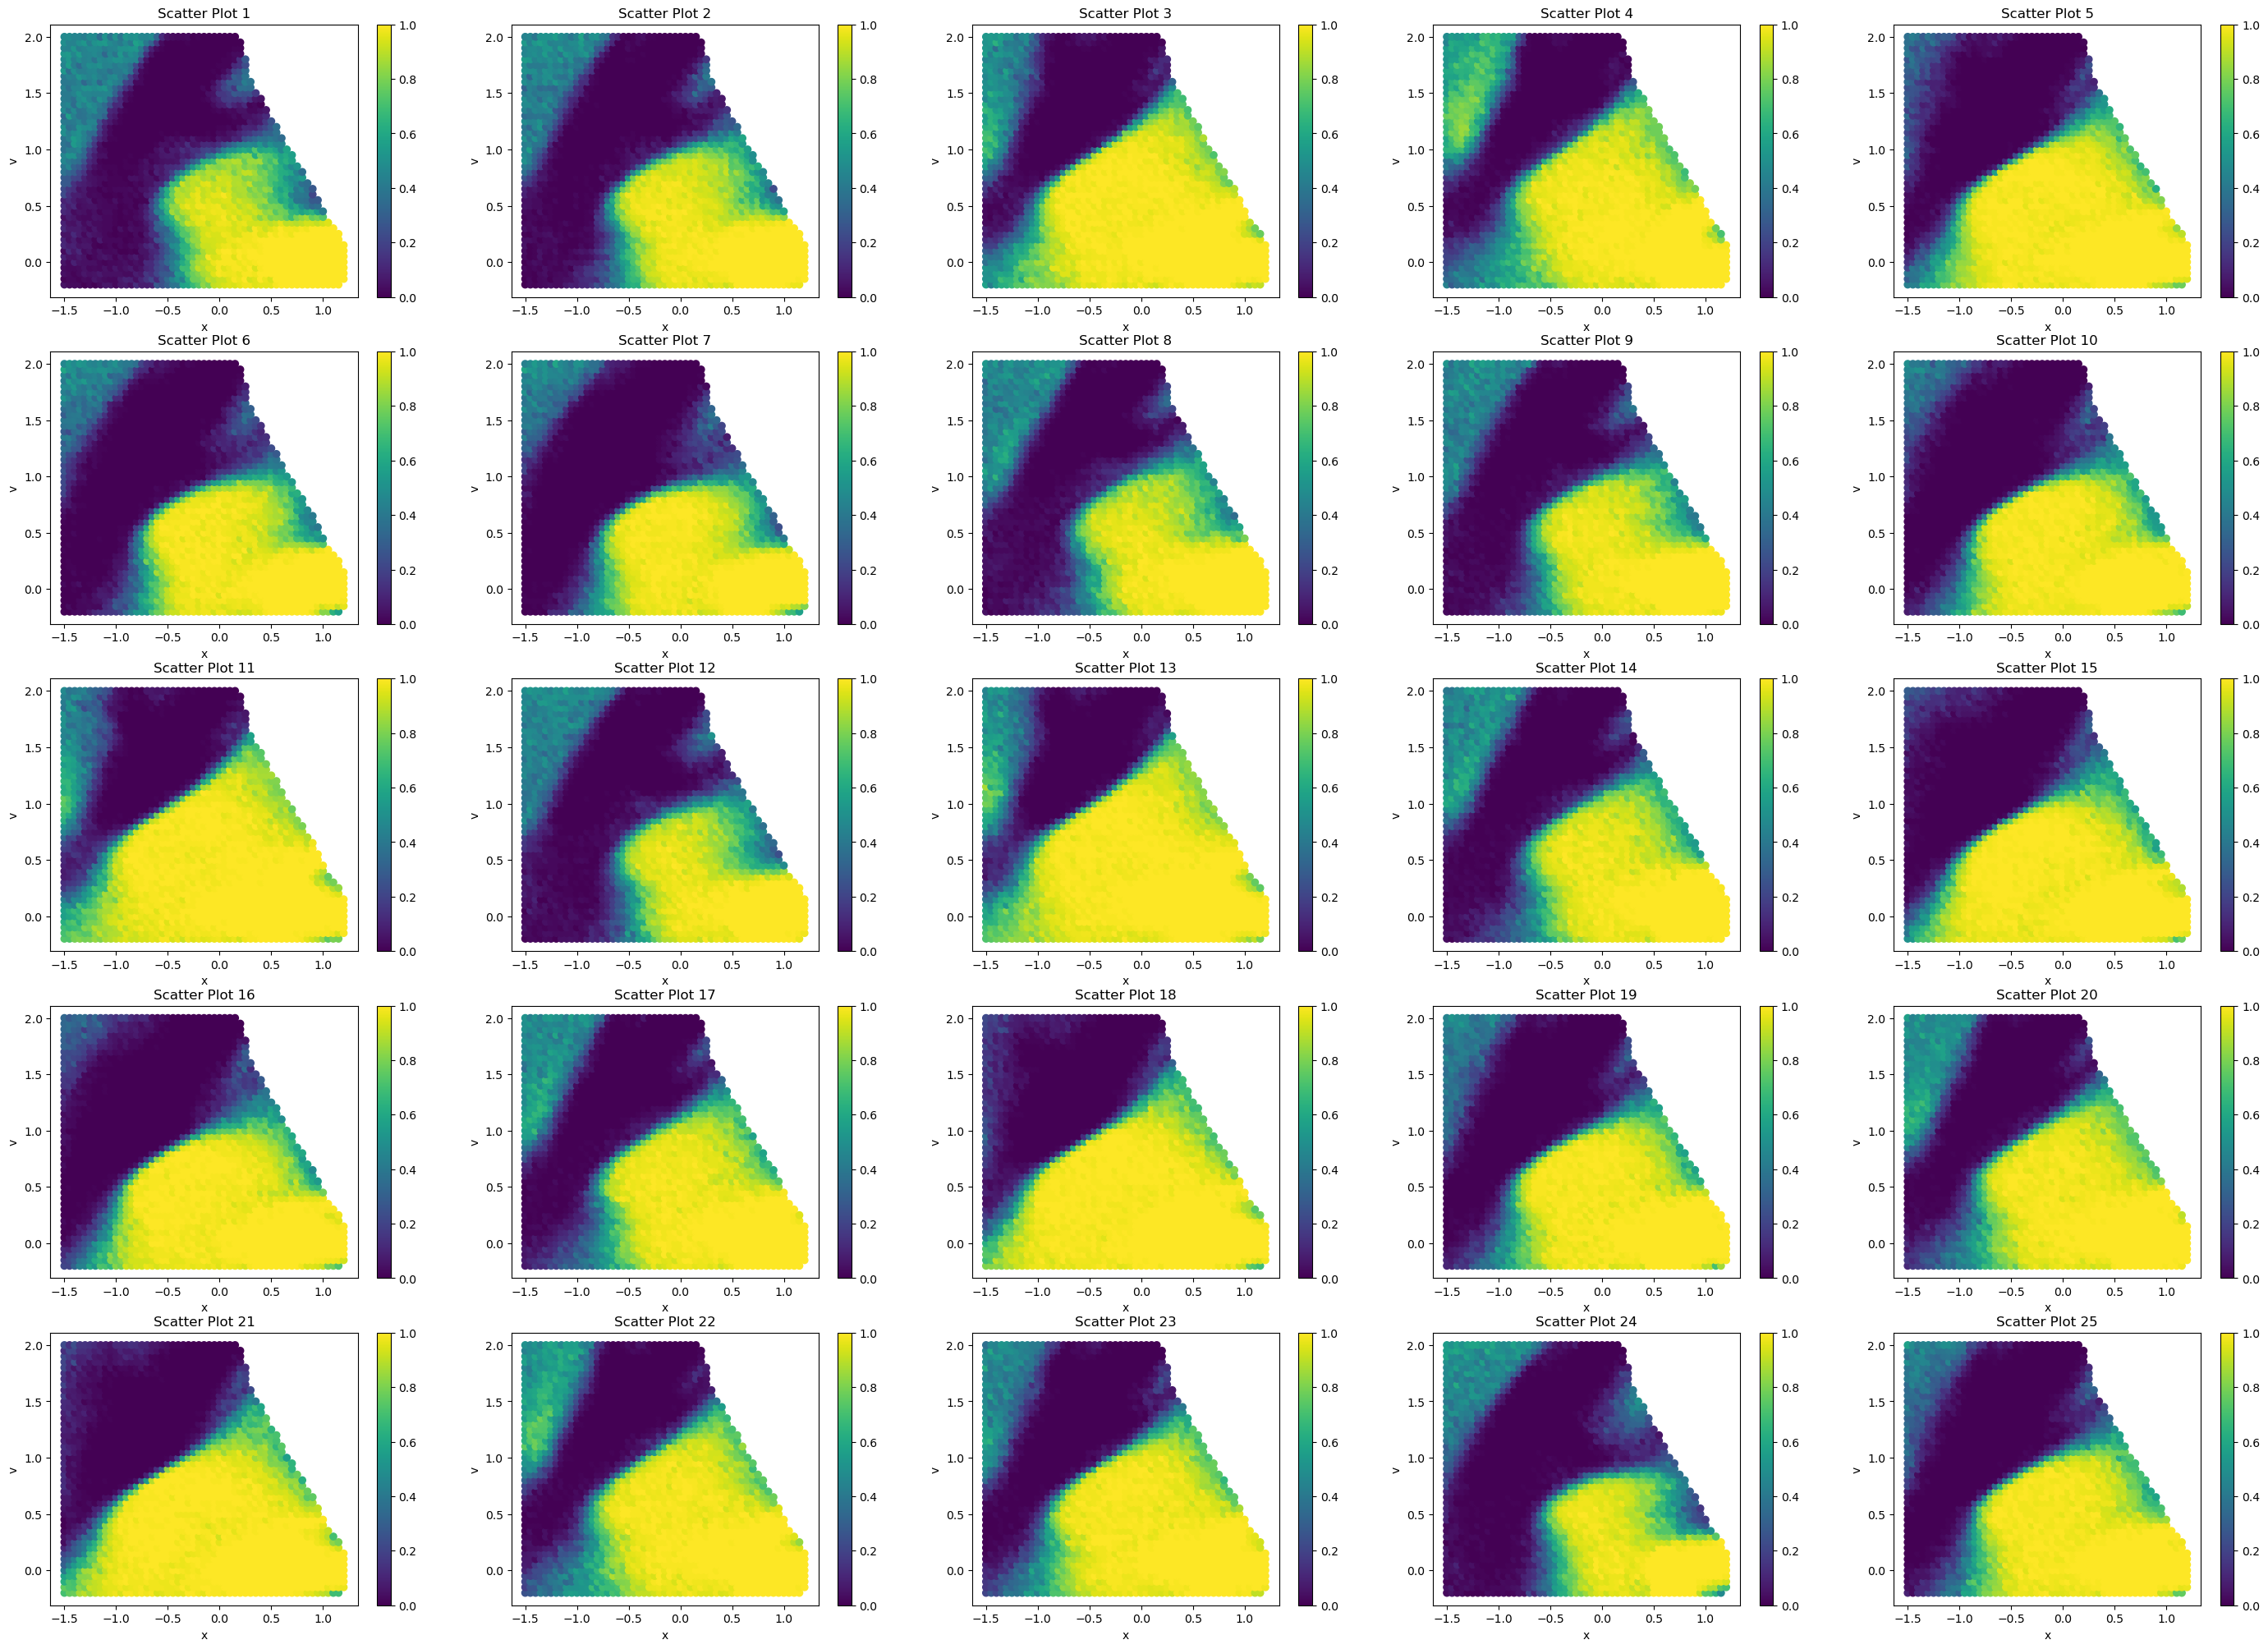

In [ ]:
mm=5
nn=5
fig, axs = plt.subplots(mm, nn, figsize=(mm*7, nn*5))  
q.to(device)

# Generate random data for each subplot  
for i in range(mm):  
    for j in range(nn):  
        idx = j+nn*i
        vvm1 = vs[idx,:]
        '''
        ddd.requires_grad_(False)
        ddd[:,(ndim):] = vvm1
        ddd.requires_grad_(True)
        dU1 = potential.gradient(ddd[:,:ndim])
        pinn_l = pinn_loss(q(ddd),ddd,dU1,args)
        pinn_l = pinn_l.detach().cpu().numpy()
        qqq1 = q(ddd).squeeze().to('cpu').detach() 
        '''
        simulation = np.loadtxt(f'model/simulation_{kbt}/simulation_kbt{kbt}_gamma{gamma}_{idx}_2.txt')
        ddd = np.zeros(shape=(simulation.shape[0],2*ndim),dtype=np.float32)
        ddd[:,:ndim] = simulation[:,:ndim]
        ddd[:,ndim:] = vvm1
        ddd = torch.from_numpy(ddd).to(device)
        ddd.requires_grad_(True)
        qqq = q(ddd).detach().squeeze().cpu().numpy()
        
        # Create scatter plot  
        sc=axs[i, j].scatter(simulation[:,0],simulation[:,1],c=simulation[:,2])  
        axs[i, j].set_title(f'Scatter Plot {idx+1}')  
        axs[i, j].set_xlabel('x')  
        axs[i, j].set_ylabel('v')
        fig.colorbar(sc, ax=axs[i,j])



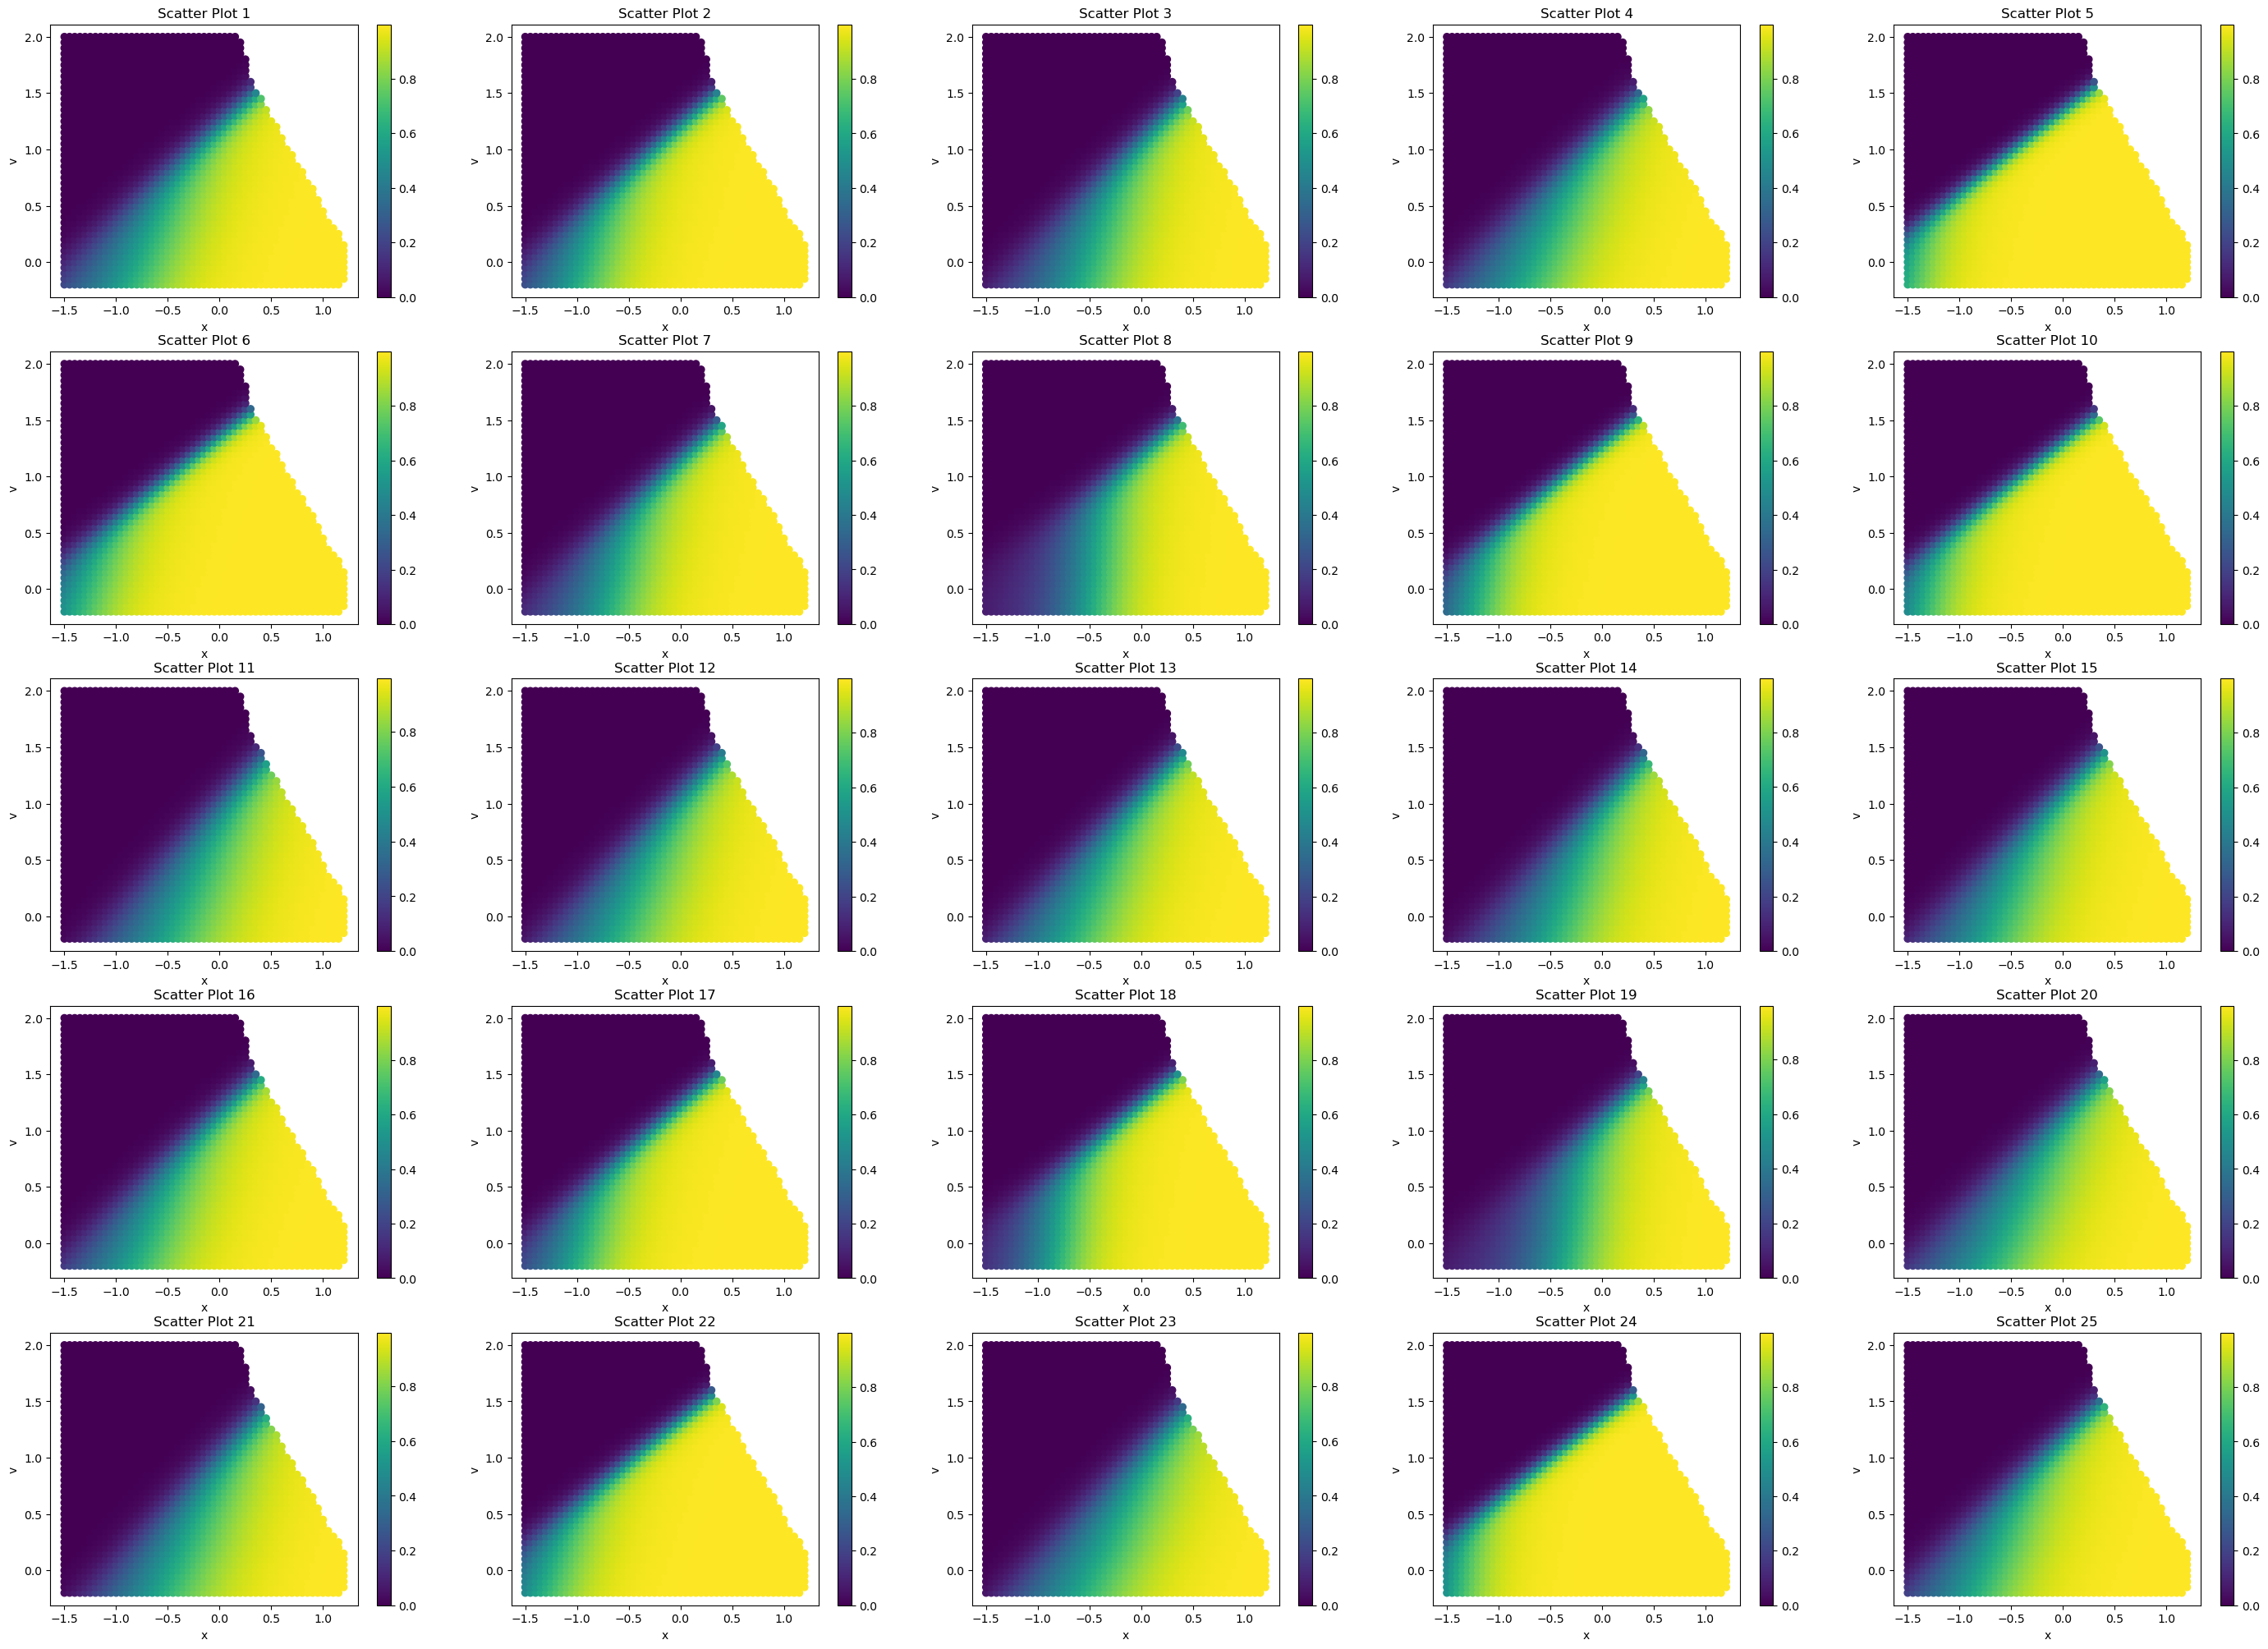

In [ ]:
mm=5
nn=5
fig, axs = plt.subplots(mm, nn, figsize=(mm*7, nn*5))  
q.to(device)

# Generate random data for each subplot  
for i in range(mm):  
    for j in range(nn):  
        idx = j+nn*i
        vvm1 = vs[idx,:]
        '''
        ddd.requires_grad_(False)
        ddd[:,(ndim):] = vvm1
        ddd.requires_grad_(True)
        dU1 = potential.gradient(ddd[:,:ndim])
        pinn_l = pinn_loss(q(ddd),ddd,dU1,args)
        pinn_l = pinn_l.detach().cpu().numpy()
        qqq1 = q(ddd).squeeze().to('cpu').detach() 
        '''
        simulation = np.loadtxt(f'model/simulation_{kbt}/simulation_kbt{kbt}_gamma{gamma}_{idx}_2.txt')
        ddd = np.zeros(shape=(simulation.shape[0],2*ndim),dtype=np.float32)
        ddd[:,:ndim] = simulation[:,:ndim]
        ddd[:,ndim:] = vvm1
        ddd = torch.from_numpy(ddd).to(device)
        ddd.requires_grad_(True)
        qqq = q(ddd).detach().squeeze().cpu().numpy()
        
        # Create scatter plot  
        sc=axs[i, j].scatter(simulation[:,0],simulation[:,1],c=qqq)  
        axs[i, j].set_title(f'Scatter Plot {idx+1}')  
        axs[i, j].set_xlabel('x')  
        axs[i, j].set_ylabel('v')
        fig.colorbar(sc, ax=axs[i,j])



Absolute error: 0.012861657774932719
Reletive error: 0.08065683111104367
l2 norm: 0.1594614814116058


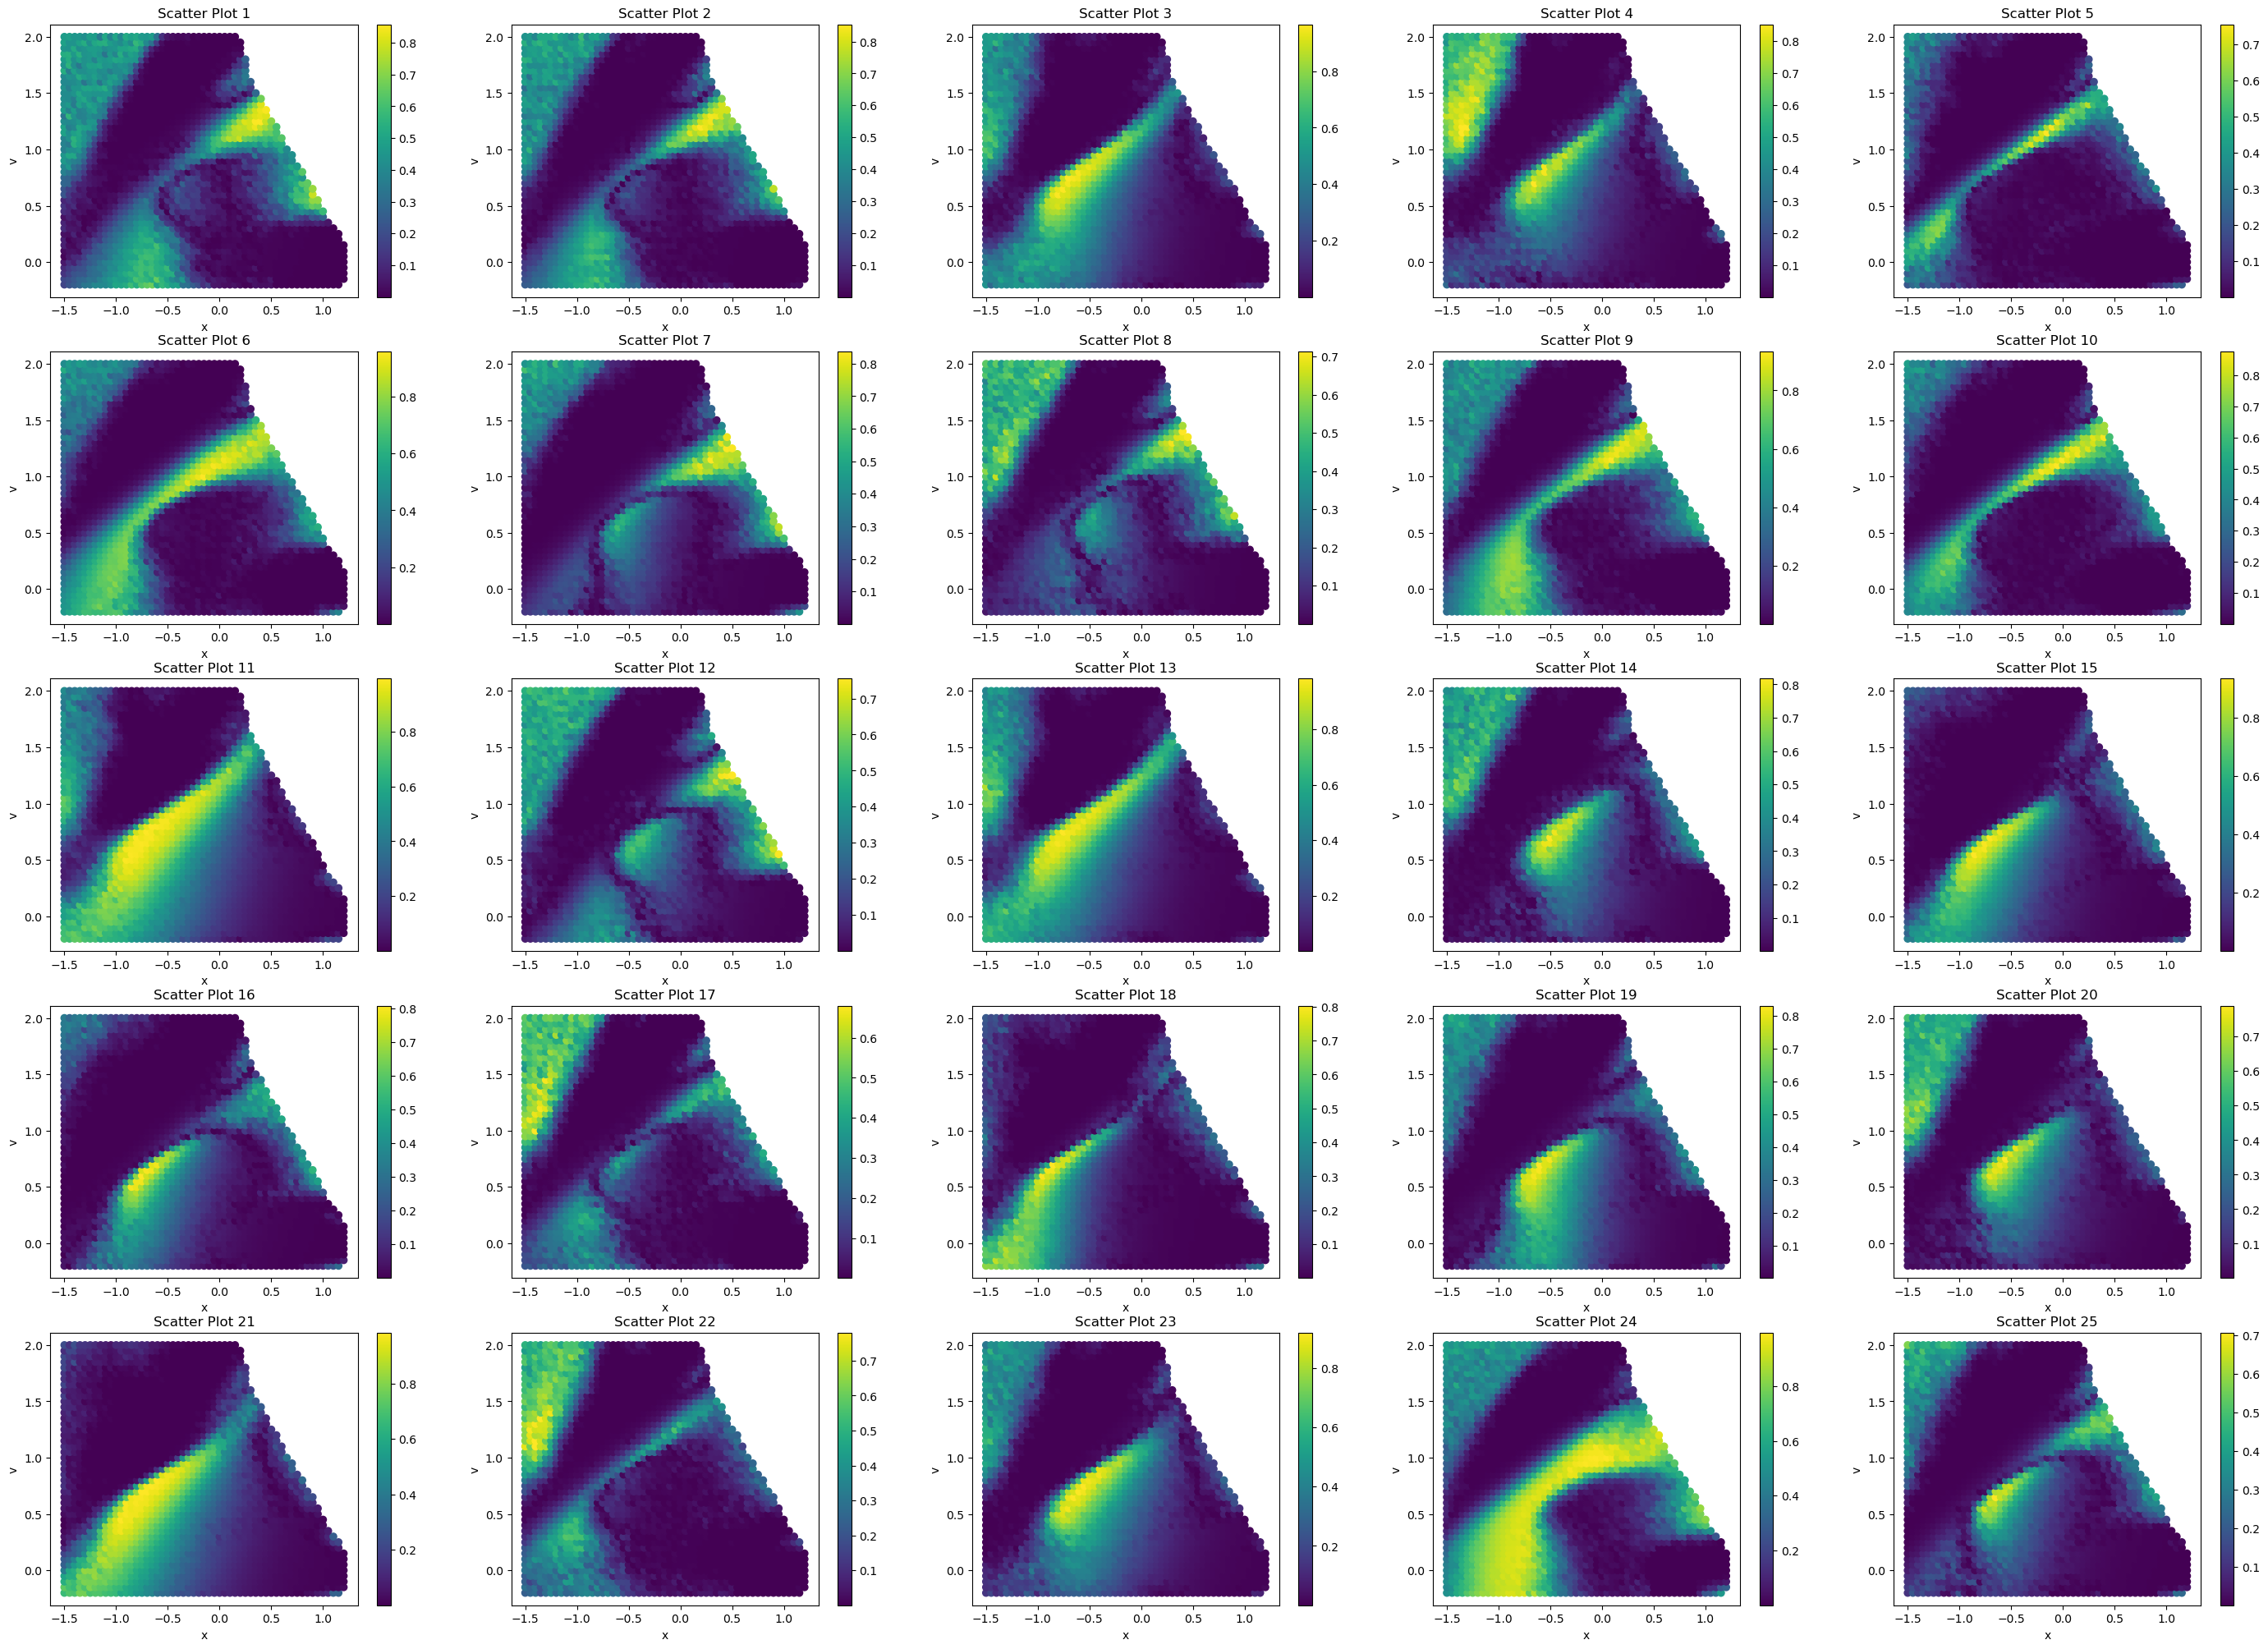

In [ ]:
mm=5
nn=5
fig, axs = plt.subplots(mm, nn, figsize=(mm*7, nn*5))  
q.to(device)
l2_loss = 0
l2_norm = 0


# Generate random data for each subplot  
for i in range(mm):  
    for j in range(nn):  
        idx = j+nn*i
        vvm1 = vs[idx,:]
        '''
        ddd.requires_grad_(False)
        ddd[:,(ndim):] = vvm1
        ddd.requires_grad_(True)
        dU1 = potential.gradient(ddd[:,:ndim])
        pinn_l = pinn_loss(q(ddd),ddd,dU1,args)
        pinn_l = pinn_l.detach().cpu().numpy()
        qqq1 = q(ddd).squeeze().to('cpu').detach() 
        '''
        simulation = np.loadtxt(f'model/simulation_{kbt}/simulation_kbt{kbt}_gamma{gamma}_{idx}_2.txt')
        ddd = np.zeros(shape=(simulation.shape[0],2*ndim),dtype=np.float32)
        ddd[:,:ndim] = simulation[:,:ndim]
        ddd[:,ndim:] = vvm1
        ddd = torch.from_numpy(ddd).to(device)
        ddd.requires_grad_(True)
        qqq = q(ddd).detach().squeeze().cpu().numpy()
        
        # Create scatter plot  
        sc=axs[i, j].scatter(simulation[:,0],simulation[:,1],c=np.abs(qqq-simulation[:,2]))  
        axs[i, j].set_title(f'Scatter Plot {idx+1}')  
        axs[i, j].set_xlabel('x')  
        axs[i, j].set_ylabel('v')
        fig.colorbar(sc, ax=axs[i,j])
        MP = MullerPotential()
        U = MP.potential(simulation[:,0:ndim])
        p = np.exp(-(U-min(U))/kbt)
        p = p/np.sum(p)
        l2_loss += np.sum(p*np.abs(qqq-simulation[:,2])**2)
        l2_norm += np.sum(p*simulation[:,2]**2)

l2_loss /= mm*nn
l2_norm /= mm*nn 
print(f'Absolute error: {l2_loss**0.5}')
print(f'Reletive error: {l2_loss**0.5/l2_norm**0.5}')
print(f'l2 norm: {l2_norm**0.5}')



In [ ]:
#simulation = np.loadtxt('./model/simulation_kbt.1_gamma10.txt')
q0 = np.loadtxt('./model/fd_kbt10.txt')
#q_simulation = np.loadtxt('./model/q_s_1d.txt')


In [ ]:
'''
plt.scatter(simulation[:,0],simulation[:,1],c=simulation[:,2])
plt.colorbar()
plt.show()
'''

'\nplt.scatter(simulation[:,0],simulation[:,1],c=simulation[:,2])\nplt.colorbar()\nplt.show()\n'

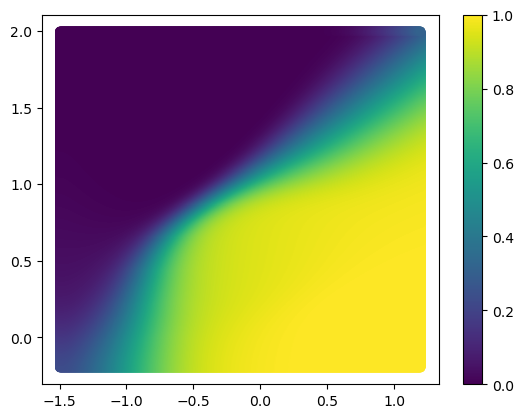

In [ ]:
plt.scatter(q0[:,0],q0[:,1],c=q0[:,2])
plt.colorbar()
plt.show()

In [ ]:
ddd = torch.zeros(size=(q0.shape[0],2*ndim)).to(device)

ddd[:,:ndim] = torch.from_numpy(q0[:,:ndim]).to(device)
ddd[:,ndim:] = 0
qqq = torch.zeros(size=(ddd.shape[0],1),dtype=torch.float32,device=device)
NNN = 1000
with torch.no_grad():
    for ttt in range(NNN):
        
        ddd[:,ndim:] = torch.randn(size=(1,ndim),device=device)*torch.ones(size=(ddd.shape[0],ndim),device=device)*np.sqrt(kbt)
        #print(ddd.shape)
        temp = q(ddd)
        
        #print(ddd.shape,temp.shape)
        qqq += temp

qqq = qqq/NNN
qqq = qqq.squeeze().to('cpu').detach()



KeyboardInterrupt: 

In [ ]:
ddd = torch.zeros(size=(q0.shape[0],2*ndim),dtype=torch.float32)
ddd[:,:ndim] = torch.from_numpy(q0[:,:ndim])
label = torch.from_numpy(q0[:,ndim].astype(np.float32))

activ = 'sigmoid'
qq = FunctionModel(layer_sizes=layers,activation=activ)
qq.to(device)
ddd=ddd.to(device)
label = label.to(device).unsqueeze(dim=1)
lossfunction = torch.nn.MSELoss()
opt = optim.Adam(qq.parameters(),lr = 1e-4)
num_epoches = 200
for _ in range(num_epoches):
    opt.zero_grad()
    loss = lossfunction(qq(ddd),label)
    loss.backward()
    opt.step()


In [ ]:
xmin, xmax = -1.5, 1.2
ymin, ymax = -0.2, 2
dx = 0.01
dy = 0.01
Nx = int((xmax - xmin) / dx)
Ny = int((ymax - ymin) / dy)


Ncol = Nx + 1
Nrow = Ny + 1
x = np.linspace(xmin, xmax, Nx + 1)
y = np.linspace(ymin, ymax, Ny + 1)

if Ncol == Nx - 1:
    xcal = x[1:-1]
else:
    xcal = x

if Nrow == Ny - 1:
    ycal = y[1:-1]
else:
    ycal = y


X, Y = np.meshgrid(xcal, ycal)
# print(X.shape, V)

points = np.array([X.reshape(-1), Y.reshape(-1)]).T.astype(np.float32)
'''
c = np.arange(len(points))
plt.scatter(points[:, 0], points[:, 1], c=c)
plt.colorbar()
plt.show()
'''
N_matrix = Nrow * Ncol

ddd = torch.zeros(size=(points.shape[0],2*ndim)).to(device)

ddd[:,:ndim] = torch.from_numpy(points).to(device)
ddd[:,ndim:] = 0
qqqq = qq(ddd).squeeze().to('cpu').detach()


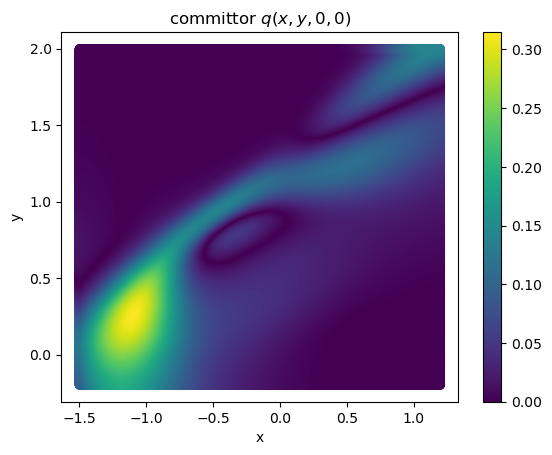

In [ ]:
ttt = np.abs(q0[:,2]-qqq.numpy())
#ttt[ttt>0.3] = 0.3
plt.scatter(q0[:,0], q0[:,1], c=ttt)
plt.title('committor $q(x,y,0,0)$')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [ ]:
MP = MullerPotential()
U = MP.potential(q0[:,:ndim])
p = np.exp(-(U-min(U))/kbt)
p = p/np.sum(p)
print(f'Absolute error: {np.sum(p*ttt**2)**0.5}')
print(f'Reletive error: {np.sum(p*ttt**2)**0.5/np.sum(p*q0[:,2]**2)**0.5}')
print(f'l2 norm: {np.sum(p*q0[:,2]**2)**0.5}')

Absolute error: 0.0029245098551967316
Reletive error: 0.018416811226324506
l2 norm: 0.15879566876466183


In [ ]:
'''
plt.scatter(points[:, 0], points[:, 1], c=qqq)
plt.title('committor $q(x,v)$')
plt.xlabel('x')
plt.ylabel('v')
plt.colorbar()
plt.show()
'''

"\nplt.scatter(points[:, 0], points[:, 1], c=qqq)\nplt.title('committor $q(x,v)$')\nplt.xlabel('x')\nplt.ylabel('v')\nplt.colorbar()\nplt.show()\n"

In [ ]:
'''
vslice = 0.0
Q = qqq.reshape(X.shape)
Qfd = fd[:,2].reshape(X.shape)
#plt.plot(xcal[::10], Q[int((vslice-vmin)/dv), ::10]-Qfd[int((vslice-vmin)/dv), ::10])
plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :]-Qfd[int((vslice-vmin)/dv), :])
plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :],'r')
plt.plot(xcal[:], q0,'g')
plt.plot(xcal[:],Qfd[int((vslice-vmin)/dv), :],'b')
#plt.plot(xcal, Q[int((vslice-vmin)/dv), :])
plt.xlabel('x')
plt.ylabel('q')
plt.title(f'slice with v={vslice}')
plt.show()
'''

"\nvslice = 0.0\nQ = qqq.reshape(X.shape)\nQfd = fd[:,2].reshape(X.shape)\n#plt.plot(xcal[::10], Q[int((vslice-vmin)/dv), ::10]-Qfd[int((vslice-vmin)/dv), ::10])\nplt.plot(xcal[:], Q[int((vslice-vmin)/dv), :]-Qfd[int((vslice-vmin)/dv), :])\nplt.plot(xcal[:], Q[int((vslice-vmin)/dv), :],'r')\nplt.plot(xcal[:], q0,'g')\nplt.plot(xcal[:],Qfd[int((vslice-vmin)/dv), :],'b')\n#plt.plot(xcal, Q[int((vslice-vmin)/dv), :])\nplt.xlabel('x')\nplt.ylabel('q')\nplt.title(f'slice with v={vslice}')\nplt.show()\n"

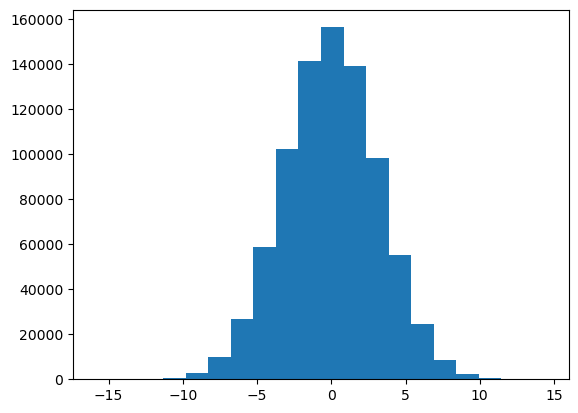

In [ ]:
plt.hist(data.to('cpu').detach().numpy()[:,3],bins=20)
plt.show()

In [ ]:
model_file = f'./model/gamma{gamma}_kbt{kbt}.pth'
config_file = f'./config/gamma{gamma}_kbt{kbt}.txt'
save_model(q,model_file,config_file)

Model saved to ./config/gamma5_kbt10.txt
Model saved to ./model/gamma5_kbt10.pth
